<a href="https://colab.research.google.com/github/fruzsi91/bigdata/blob/master/Marki_Zay_102021_082022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import PyDrive and associated libraries
# This only needs to be done once per notebook
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
# This only needs to be done once per notebook
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
!pip install contractions
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import json
import datetime
import plotly.express as px
import plotly.graph_objects as go
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

import html
import re
import contractions

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

import string

from wordcloud import WordCloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 KB 12.3 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# Download a file based on its file ID.

# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1e1ac-u5OyRdnpSqpAXsbgkfihbppWOpV' # Check your own ID in GDrive
downloaded = drive.CreateFile({'id': file_id})

# Save file in Colab memory
downloaded.GetContentFile('Marki-Zay_mod01.csv')

# Exploratory data analysis

## Introduction of the dataset

In [4]:
df = pd.read_csv('Marki-Zay_mod01.csv', sep = ';')
df.head()

tweet_id                                    tweet_full_text  \
0  1448367197332459525  Egymásnak esve közeledett egymáshoz Dobrev Klá...   
1  1448365720690171905  RT @balazscseko: While the two remaining oppos...   
2  1448365408650682368  RT @balazscseko: While the two remaining oppos...   
3  1448363079255920649  RT @MiHazank: Hazaárulókat sem restell támogat...   
4  1448361274446856200  While the two remaining opposition candidates ...   

      tweet_created_at  tweet_retweet_count  tweet_favorite_count  \
0  2021-10-13 19:17:03                    0                     1   
1  2021-10-13 19:11:11                    2                     0   
2  2021-10-13 19:09:57                    2                     0   
3  2021-10-13 19:00:42                    3                     0   
4  2021-10-13 18:53:31                    2                     3   

         tweet_user_id tweet_hashtags       user_name user_screen_name  \
0             17021282             []          hvg.hu           hvg_hu   
1  1210634434434752513    ['Hungary']  Róbert Nádasdy          RNascal   
2             26786894    ['Hungary']      Lydia Gall            LydsG   
3   956210929661890561             []     Arany Gábor   Arany_Gabor_14   
4           1270678909    ['Hungary']    Balazs Csekö      balazscseko   

           user_location                                   user_description  \
0               Budapest  Ami mellett nem érdemes elmenni. Gyorshírek, a...   
1                    NaN  Szeretem a kihívásokat, repülést ejtőernyőzést...   
2               Budapest  Senior researcher on Eastern EU and Western Ba...   
3                    NaN                                                NaN   
4  Vienna, Budapest, CEE  Journalist & pol scientist. Author: Cuban Exil...   

       user_created_at  user_followers_count  user_friends_count  \
0  2008-10-28 13:57:54                369674                 461   
1  2019-12-27 18:53:13                   517                2402   
2  2009-03-26 16:32:50                  8855                 934   
3  2018-01-24 17:03:45                     2                  11   
4  2013-03-15 20:47:04                  7092                3154   

   user_favourites_count  user_statuses_count  user_listed_count  \
0                      1               158356                414   
1                  17652                78130                  3   
2                   2520                 6584                346   
3                   1303                   27                  0   
4                   3570                 8255                247   

  tweet_language    original_tweet_id  
0             hu                 None  
1             ro  1448361274446856200  
2             ro  1448361274446856200  
3             hu  1447995048809877511  
4             ro                 None

## Number of tweets and retweets

In [5]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} tweets)".format(pct, absolute)


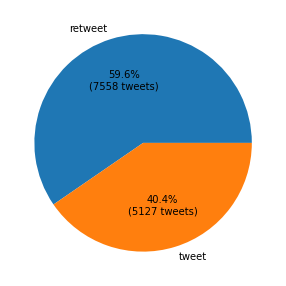

In [6]:
df.loc[df['original_tweet_id'] == 'None', 'retweet_tweet'] = 'tweet'
df['retweet_tweet'].fillna('retweet', inplace = True)

num_of_t = df.groupby('retweet_tweet')['tweet_id'].count()
fig = plt.figure(figsize = (5,5))

plt.pie(num_of_t,
        labels = num_of_t.index,
        autopct=lambda pct: func(pct, num_of_t))
plt.show()

## Tweet created at before and after the election

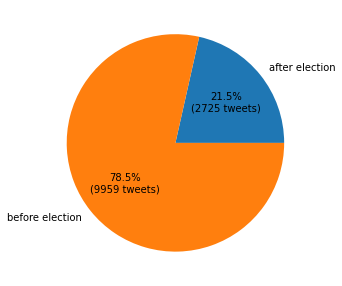

In [7]:
df.loc[df['tweet_created_at'] < '2022-04-03 00:00:00', 'before_after'] = 'before election'
df['before_after'].fillna('after election', inplace = True)

num_of_t_elect = df.groupby('before_after')['tweet_id'].count()
fig = plt.figure(figsize = (5,5))

plt.pie(num_of_t_elect,
        labels = num_of_t_elect.index,
        autopct=lambda pct: func(pct, num_of_t_elect))
plt.show()

## Tweets timeline

### All tweets

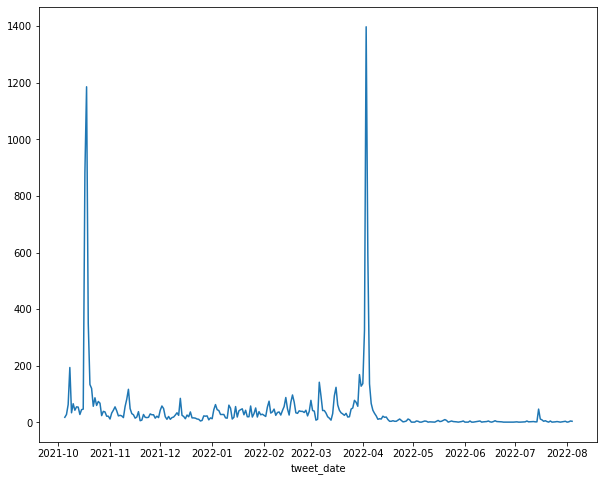

In [8]:
df['tweet_date'] = pd.to_datetime(df['tweet_created_at']).dt.date
df.groupby(['tweet_date'])['tweet_id'].count()\
.plot(kind = 'line', figsize = (10, 8))
plt.show()

### Just tweets

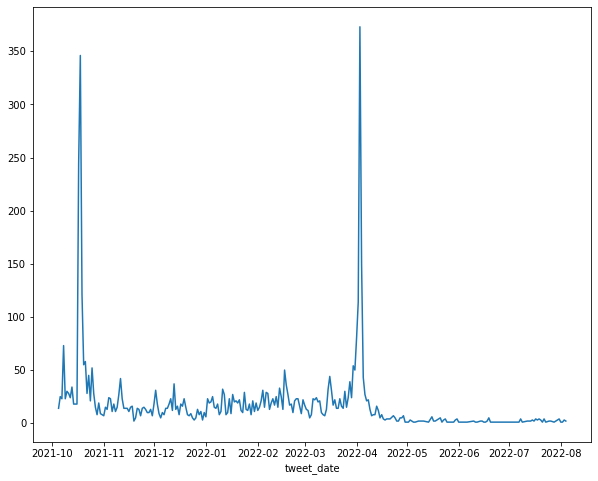

In [9]:
df[df['original_tweet_id'] == 'None']\
.groupby(['tweet_date'])['tweet_id'].count()\
.plot(kind = 'line', figsize = (10, 8))
plt.show()

## Tweets language

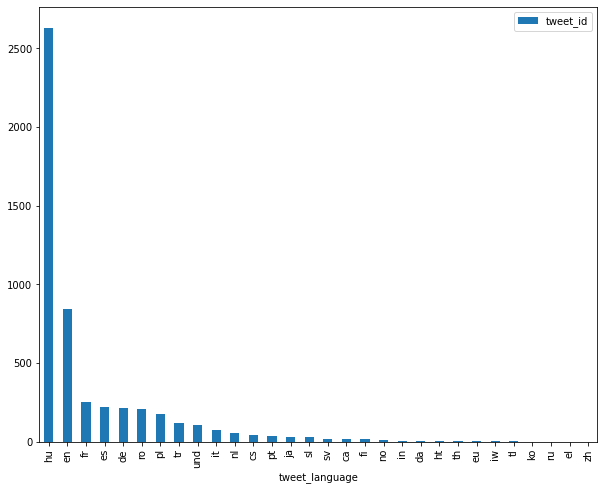

In [10]:
df[df['original_tweet_id'] == 'None']\
    .groupby(['tweet_language'], as_index = False)['tweet_id'].count()\
    .sort_values('tweet_id', ascending = False)\
    .set_index('tweet_language')\
    .plot(kind = 'bar', figsize = (10, 8))
plt.show()

## Used hashtags

In [11]:
dictionary = {}
for x,y in df.iterrows():
    res = []
    res = json.loads(y['tweet_hashtags'].replace('\'', '"'))
    for i in res:
        if i in dictionary.keys():
            dictionary[i]+=1
        else:
            dictionary[i]=1

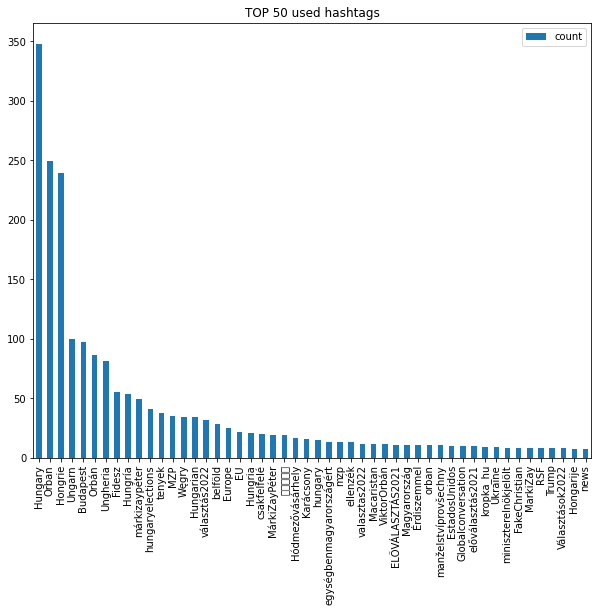

In [12]:
hashtags = pd.DataFrame\
          .from_dict(dictionary, orient = 'index')\
          .rename(columns = {0: 'count'})\
          .sort_values('count', ascending = False)

hashtags.head(50)\
        .plot(kind = 'bar',figsize = (10, 8))
        
plt.title('TOP 50 used hashtags')
plt.show()

## Tweet location

In [13]:
# Download a file based on its file ID.

# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1Z-L97CYmiBROl2DI3Bq5Lhq5Q0xiu5BI' # Check your own ID in GDrive
downloaded = drive.CreateFile({'id': file_id})

# Save file in Colab memory
downloaded.GetContentFile('all_detected.csv')  

### Location exists for tweets and retweets

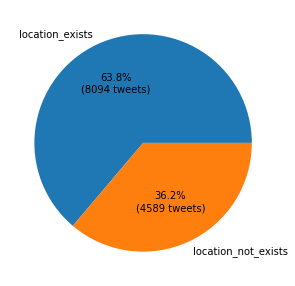

In [14]:
df.loc[df['user_location'].isnull(), 'location'] = 'location_not_exists'
df['location'].fillna('location_exists', inplace = True)

df_loc_exists = df.groupby(['location'])['tweet_id'].count()

fig = plt.figure(figsize = (5,5))

plt.pie(df_loc_exists,
        labels = df_loc_exists.index,
        autopct=lambda pct: func(pct, df_loc_exists))
plt.show()

### Location exists for only tweets

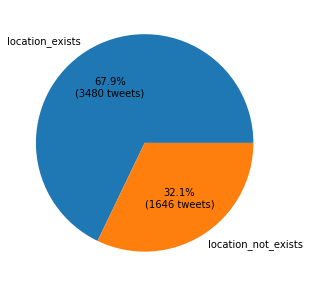

In [15]:
df_loc_exists_tweet = df[df['original_tweet_id'] == 'None']\
.groupby(['location'])['tweet_id'].count()

fig = plt.figure(figsize = (5,5))

plt.pie(df_loc_exists_tweet,
        labels = df_loc_exists_tweet.index,
        autopct=lambda pct: func(pct, df_loc_exists_tweet))
plt.show()

### Load detected locations

In [16]:
df_loc = pd.read_csv('all_detected.csv', sep = ';')

In [17]:
df_detected_locations = df[df['location'] == 'location_exists']\
                        .merge(df_loc, on = 'tweet_id', how = 'outer')
                        
df_detected_locations.loc[df_detected_locations['country'] == 'HUNGARY', 'country'] = 'Hungary'
df_detected_locations.loc[df_detected_locations['country'] == 'FRANCE', 'country'] = 'France'
df_detected_locations.loc[df_detected_locations['country'] == 'CHILE', 'country'] = 'Chile'
df_detected_locations.loc[df_detected_locations['country'] == 'TURKEY', 'country'] = 'Turkey'
df_detected_locations.loc[df_detected_locations['country'] == 'INDIA', 'country'] = 'India'
df_detected_locations.loc[df_detected_locations['country'] == 'ARGENTINA', 'country'] = 'Argentina'

df_detected_locations['country'].fillna('Other', inplace = True)

df_detected_locations\
.loc[df_detected_locations['user_location'].str.contains('Nederland'), 'country'] = 'Netherlands'
df_detected_locations\
.loc[df_detected_locations['user_location'].str.contains('Amsterdam'), 'country'] = 'Netherlands'
df_detected_locations\
.loc[df_detected_locations['user_location'].str.contains('United Kingdom'), 'country'] = 'United Kingdom'
df_detected_locations\
.loc[df_detected_locations['user_location'].str.contains('England'), 'country'] = 'England'

#### Detected country list

In [18]:
df_detected_locations\
.groupby(['country'], as_index = False)['tweet_id'].count()\
.sort_values('tweet_id', ascending = False)

country  tweet_id
37                                  Hungary      2580
64                                    Other      1750
93                            United States       626
28                                   France       425
30                                  Germany       350
92                           United Kingdom       250
68                                   Poland       236
84                                    Spain       179
7                                   Belgium       147
43                                    Italy       113
59                              Netherlands       111
24                                  England       108
85                                   Sweden        90
3                                   Austria        89
26                                   Europe        74
89                                   Turkey        66
11                                   Canada        65
81                                 Slovenia        62
27                                  Finland        46
86                              Switzerland        40
18                                  Czechia        39
63                                   Norway        36
1                                 Argentina        35
2                                 Australia        35
66                                     Peru        33
69                                  Poland         32
80                                 Slovakia        30
17                           Czech Republic        29
9                                    Brazil        28
39                                    India        25
74                                  Romania        25
70                                 Portugal        22
12                                    Chile        21
41                                  Ireland        18
55                                   Mexico        17
45                                    Japan        16
99                                    World        13
90                                  Ukraine        12
97                                Venezuela        12
71                              Puerto Rico        12
19                                  Denmark        11
47                                    Kenya        10
101                                   india         8
77                                   Serbia         8
31                                   Greece         8
98        Venezuela, Bolivarian Republic of         8
25                                  Estonia         7
40                                Indonesia         7
14                                 Colombia         7
42                                   Israel         6
53                                 Malaysia         5
83                             South Africa         5
16                                  Croatia         5
79                          Slovak Republic         5
29                                  Georgia         5
36                                Hong Kong         5
65                                 Pakistan         4
61                                  Nigeria         4
10                                 Bulgaria         4
56                                  Morocco         4
54                                    Malta         4
95                                  Uruguay         4
23                              El Salvador         4
91                     United Arab Emirates         3
57                                  Myanmar         3
49                                   Latvia         3
73                       Republic of Serbia         3
38                                  Iceland         3
52                               Luxembourg         3
5                                   Bahrain         2
72                                    Qatar         2
94                 United States of America         2
67                              Philippines         2
15                               Costa R

#### Top 50 countries of all tweets

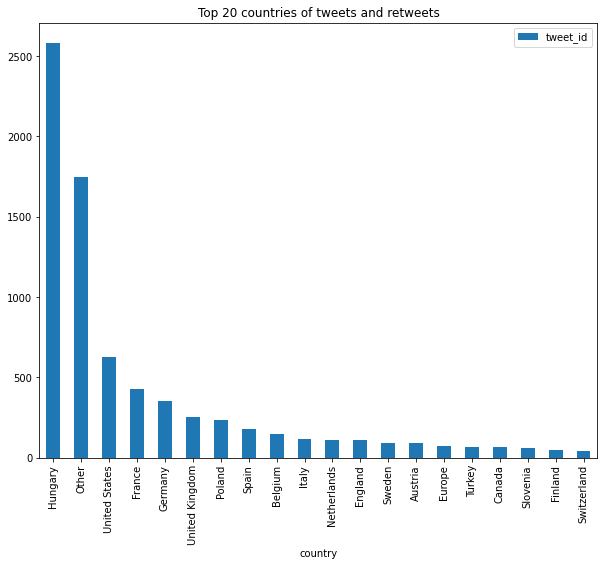

In [19]:
df_detected_locations\
.groupby(['country'], as_index = False)['tweet_id'].count()\
.sort_values('tweet_id', ascending = False).set_index('country').head(20)\
.plot(kind = 'bar',figsize = (10, 8))

plt.title('Top 20 countries of tweets and retweets')
plt.show()

#### Top 50 countries of only tweets

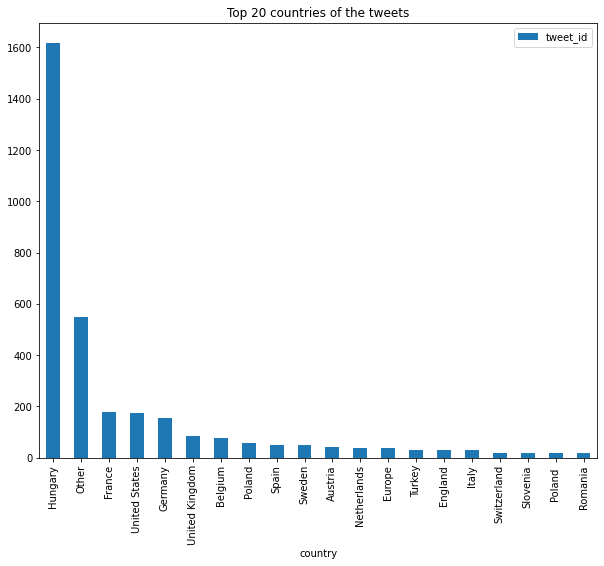

In [20]:
df_detected_locations[df_detected_locations['original_tweet_id'] == 'None']\
.groupby(['country'], as_index = False)['tweet_id'].count()\
.sort_values('tweet_id', ascending = False).set_index('country').head(20)\
.plot(kind = 'bar',figsize = (10, 8))

plt.title('Top 20 countries of the tweets')
plt.show()

#### Top 50 original user locations of all tweets

In [21]:
df[df['location']== 'location_exists']\
.groupby('user_location', as_index = False)['tweet_id'].count()\
.sort_values('tweet_id', ascending = False)\
.head(50)

user_location  tweet_id
355                Budapest, Hungary       406
341                         Budapest       402
361           Budapest, Magyarország       264
6      Budapest, Hungary                   187
1192                    Magyarország       186
931                 Hódmezővásárhely       165
915                          Hungary       151
1725                 SZEGED, HUNGARY       138
2244                        budapest       118
2375      Ózd, Magyarország, Hungary       103
1581                          Polska        69
2139                Warszawa, Polska        68
1507                           Paris        66
728                           France        60
666                           Europe        55
2082               Velence / Hungary        55
312                         Brussels        55
1522                   Paris, France        53
1133                          London        52
314                Brussels, Belgium        48
781                          Germany        46
1224                Mare Moscoviense        43
1145                 London, England        42
1883                          Sweden        42
2180                Wien, Österreich        40
205                           Berlin        39
218                  Berlin, Germany        36
1897       Szombathely, Magyarország        35
1571                          Poland        34
2035                   United States        34
2100                 Vienna, Austria        33
556                      Deutschland        33
2133                        Warszawa        32
354                Budapest, Hongrie        29
2097                          Vienna        29
1863               Stockholm, Sweden        28
2152                  Washington, DC        28
1894             Szentendre, Hungary        28
2130                  Warsaw, Poland        26
1892            Szeged, Magyarország        26
507                     Csíkszereda         25
650                           España        24
1198          Magyarország, Budapest        23
214              Berlin, Deutschland        22
2276                       hong kong        22
2385               İstanbul, Türkiye        22
403                  California, USA        21
964                           Italia        20
795                            Globe        19
1619          Prague, Czech Republic        19

### Sankey chart with locations

In [22]:
top_20_country_list = df_detected_locations[(df_detected_locations['original_tweet_id'] == 'None')&
                      (df_detected_locations['country'] != 'Other')]\
                      .groupby('country', as_index = False)['tweet_id'].count()\
                      .sort_values('tweet_id', ascending = False)\
                      .head(20)['country'].values.tolist()

In [23]:
df_retweets_detected=df_detected_locations[(df_detected_locations['original_tweet_id'] != 'None')]\
                                            [['tweet_id', 'country', 'original_tweet_id']]

df_retweets_detected['original_tweet_id'] = df_retweets_detected['original_tweet_id'].astype('int64')

df_detected_merge = df_detected_locations[(df_detected_locations['original_tweet_id'] == 'None')&
                      (df_detected_locations['country'].isin(top_20_country_list))][['tweet_id', 'country']]\
                        .merge(df_retweets_detected,
                                left_on = 'tweet_id',
                                right_on = 'original_tweet_id',
                                how = 'inner')

In [24]:
df_sankey = df_detected_merge.groupby(['country_x', 'country_y'], as_index = False)['tweet_id_x'].count()
df_sankey.columns = ['source', 'target', 'value']
df_sankey['source'] = df_sankey['source'].astype(str) + '_from'
df_sankey['target'] = df_sankey['target'].astype(str) + '_to'

unique_source_target = list(pd.unique(df_sankey[['source', 'target']].values.ravel('K')))
mapping_dict = {k: v for v, k in enumerate(unique_source_target)}

df_sankey['source'] =df_sankey['source'].map(mapping_dict)
df_sankey['target'] =df_sankey['target'].map(mapping_dict)
sankey_dict = df_sankey.to_dict(orient = 'list')

In [25]:
import plotly.io as pio 
pio.renderers.default = "colab"
fig = go.Figure(
    data = [go.Sankey(
        node = dict(
            pad = 15, 
            thickness = 20,
            line = dict(color = 'black', width = 0.5),
            label = unique_source_target,
            color = 'blue'
        ),

        link = dict(
            source = sankey_dict['source'],
            target = sankey_dict['target'],
            value = sankey_dict['value']
        )
      )]
    )
fig.update_layout(autosize=False,
    width=1000,
    height=1000)

In [26]:
fig.write_html("sankey.html")

## Media users tweeted  about MZP

In [27]:
hun = ['hvg_hu',
'Katapultmagazin',
'indexhu',
'euronewshu',
'Atlatszo',
'Telexhu',
'magyar_hirlap',
'DNewsHungary']

international = ['TheEconomist',
'lemondefr',
'the_hindu',
'France24_fr',
'elmundoes',
'bbcturkce',
'Le_Figaro',
'libe',
'derspiegel',
'Mediapart',
'Corriere',
'zeitonline',
'AFP',
'RevistaISTOE',
'republikaonline',
'tvn24',
'rtvenoticias',
'lobs',
'LEXPRESS',
'europapress',
'sternde',
'NOS',
'eldiarioes',
'Internazionale',
'rtve',
'dw_espanol',
'elconfidencial',
'LePoint',
'ZDFheute',
'tvcultura',
'SinarOnline',
'correio',
'SCMPNews',
'Publico',
'nytopinion',
'gazeta_wyborcza',
'euronews_tr',
'faznet',
'gazeteduvar',
'tazgezwitscher',
'nrc',
'OuestFrance',
'larazon_es',
'ilgiornale',
'dwnews',
'euronews',
'expresso',
'vrtnws',
'Tagesspiegel',
'NZZ',
'trtworld',
'DIEZEIT',
'sudouest',
'lesoir',
'elpais_america',
'RTBFinfo',
'humanite_fr',
'courrierinter',
'descifraguerra',
'ArtiTV_',
'srfnews',
'France24_en',
'Linkiesta',
'POLITICOEurope',
'TSFRadio',
'LaTribunahn',
'Tg3web',
'Medyascopetv',
'medyascope',
'Reuters_Health',
'lalibrebe',
'TelegraphWorld',
'ilfoglio_it',
'Polityka_pl',
'visegrad24',
'SZ_TopNews',
'TV5MONDEINFO',
'observadorpt',
'Medyanin50Tonu',
'euobs',
'cicero_online',
'oko_press',
'SPIEGEL_English',
'RSF_inter',
'RFERL',
'HLN_BE',
'TRTWorldNow',
'zeitonline_pol',
'RMF24pl',
'EURACTIV',
'laderechadiario',
'openDemocracy',
'PolsatNewsPL',
'France24_es',
'EuropeElects',
'wirtualnapolska',
'wPolityce_pl',
'SPIEGEL_alles',
'Lematinch',
'News_8',
'dw_deutsch',
'Loopsidernews',
'SZ_Politik',
'DiePressecom',
'lopinion_fr',
'euronewses',
'Knack',
'rtvslo',
'Morgenbladet',
'RadioZET_NEWS',
'NPORadio1',
'visegrad24',
'USRealityCheck',
'DeGroene',
'euronewsfr',
'Delo',
'FAZ_NET',
'LaCroix',
'BR24',
'BalkanInsight',
'kleinezeitung',
'ftbrussels',
'DziennikPL',
'LeTemps',
'WienerZeitung',
'ips_journal',
'KCBSRadio',
'F24videos',
'PR24_pl',
'agerpres',
'serbestiyetweb',
'RND_de',
'euronewspt',
'RFImag',
'romanialibera',
'vecer',
'noticiaaominuto',
'tyzdensk',
'Kontrast_at',
'dosmanzanas',
'DiePresse_Pol',
'OSW_pl',
'Ziare_com',
'VisegradInsight',
'TheWeekUK',
'VisegradInsight',
'ndnl',
'vorwaerts',
'euronewsde',
'euronewsit',
'CEuropeCentrale']



In [28]:
 users_stat = df[df['original_tweet_id'] == 'None']\
              .groupby(['user_screen_name'], as_index = False)\
              .agg(max_followers =('user_followers_count', 'max'),
                  tweet_count =('tweet_id', 'count'))\
              .sort_values('user_screen_name')

In [29]:
cds_df = df[df['original_tweet_id'] == 'None']\
        .merge(users_stat[['user_screen_name','max_followers', 'tweet_count']],
               on = 'user_screen_name',
               how = 'left')
        
cds_df.sort_values('tweet_created_at',ascending = True)
cds_df['tweet_created_at'] = pd.to_datetime(cds_df['tweet_created_at']).dt.date

In [30]:
cds_df = cds_df[['tweet_full_text', 'tweet_created_at', 'tweet_hashtags', 'max_followers', 'tweet_count' ,'user_screen_name', 'user_name']]

cds_df.loc[cds_df['user_screen_name'].isin(hun), 'media_category'] = 'hungarian_news_service'
cds_df.loc[cds_df['user_screen_name'].isin(international), 'media_category'] = 'international_news_service'
cds_df['media_category'].fillna('other_twitter_user', inplace = True)

cds_df.loc[cds_df['media_category'] != 'other_twitter_user', 'media_name'] = cds_df['user_name']
cds_df['media_name'].fillna('twitter_user', inplace = True)

cds_df['date'] = cds_df['tweet_created_at'].astype('str').str.replace('-', '').str[2:].astype('int32')


In [31]:
cds_df = cds_df[cds_df['media_name'] != 'twitter_user']
cds_df['index'] = cds_df.groupby('tweet_created_at').cumcount()

cds_df.loc[(cds_df['media_category'] == 'international_news_service')&
       (cds_df['max_followers']> 10000),'color'] = 'internartional between 10 000 and 50 000 followers'
cds_df.loc[(cds_df['media_category'] == 'international_news_service')&
       (cds_df['max_followers']> 50000),'color'] = 'internartional between 50 000 and 100 000 followers'
cds_df.loc[(cds_df['media_category'] == 'international_news_service')&
       (cds_df['max_followers']> 100000),'color'] = 'internartional above 100 000 followers'
cds_df.loc[(cds_df['media_category'] == 'hungarian_news_service'),'color'] = 'hungarian'
cds_df['color'].fillna('internartional below 10 000 followers', inplace = True)

color_discrete_map = {'internartional above 100 000 followers':'brown',
                                     'internartional between 50 000 and 100 000 followers':'gold',
                                     'internartional between 10 000 and 50 000 followers': 'khaki',
                                     'hungarian': 'blue',
                                     'internartional below 10 000 followers': 'limegreen'}

In [32]:
def text_chunking(text):
  count = -1
  x = 1
  text_ch = '<br>' + text
  for i in text:
    count += 1
    if count != 0 and count % 40 == 0:
      text_ch = text_ch[0:count + 4 * x] + '<br>' + text_ch[count + 4 * x:]
      x+=1
  return text_ch

In [33]:
cds_df['tweet_text_chunks'] = cds_df['tweet_full_text'].apply(lambda x: text_chunking(x))

In [34]:
fig = px.scatter(cds_df, 
                 x="tweet_created_at",
                 y="index",
                 color='color',
                 color_discrete_map=color_discrete_map,
                 width=1000,
                 height=600,
                 hover_data=['media_name', 'max_followers', 'date', 'tweet_count', 'tweet_hashtags', 'tweet_text_chunks'])

fig.update_layout(xaxis=dict(tickformat=":1.0f"))
fig.update_xaxes(tickformat="%Y-%m-%d",tickangle=270)
fig.update_xaxes(tickvals=['2021-11-01','2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01','2022-05-01', '2022-06-01', '2022-07-01'])
fig.write_html("media_timeline.html")

## Retweets

In [35]:
retweets = df[df['original_tweet_id']!= 'None']\
.groupby('original_tweet_id', as_index = False)['tweet_id'].count()\
.sort_values('tweet_id', ascending = False)
retweets['original_tweet_id'] = retweets['original_tweet_id'].astype('int64')

most_retweeted = retweets\
          .merge(df[['tweet_id','tweet_full_text', 'tweet_created_at', 'user_screen_name', 'tweet_language', 'user_location']],
                right_on = 'tweet_id',
                left_on = 'original_tweet_id',
                how = 'left')
del most_retweeted['tweet_id_y']

### Retweets count based on language

In [36]:
most_retweeted.groupby('tweet_language')['tweet_id_x'].sum()\
              .reset_index()\
              .sort_values('tweet_id_x', ascending = False)

tweet_language  tweet_id_x
4              en        2664
9              hu        1753
15             pl         785
5              es         489
17             ro         427
8              fr         378
3              de         263
10             it         169
21             tr         161
22            und         118
1              cs          90
13             nl          55
18             sl          53
16             pt          37
0              ca          26
7              fi          21
19             sv          13
20             th          10
12             ja           8
14             no           4
11             iw           3
2              da           2
23             zh           2
6              eu           1

### Retweets count based on date

In [37]:
most_retweeted['tweet_created_at_day'] = pd.to_datetime(most_retweeted['tweet_created_at']).dt.date
most_retweeted['tweet_created_at_month'] = pd.to_datetime(most_retweeted['tweet_created_at']).dt.month
most_retweeted.groupby('tweet_created_at_day')['tweet_id_x'].sum()\
              .reset_index()\
              .sort_values('tweet_id_x', ascending = False)\
              .head(20)

tweet_created_at_day  tweet_id_x
179           2022-04-03        1192
12            2021-10-17         988
13            2021-10-18         609
178           2022-04-02         306
180           2022-04-04         202
151           2022-03-06         169
14            2021-10-19         145
175           2022-03-30         133
3             2021-10-08         115
37            2021-11-12         103
161           2022-03-16          81
2             2021-10-07          75
15            2021-10-20          75
135           2022-02-18          72
160           2022-03-15          71
130           2022-02-13          70
146           2022-03-01          68
172           2022-03-27          60
181           2022-04-05          58
177           2022-04-01          57

### Retweets count based on month

In [38]:
most_retweeted.groupby('tweet_created_at_month')['tweet_id_x'].sum()\
              .reset_index()\
              .sort_values('tweet_id_x', ascending = False)

tweet_created_at_month  tweet_id_x
8                     10.0        2459
3                      4.0        1935
2                      3.0        1039
1                      2.0         640
0                      1.0         519
9                     11.0         502
10                    12.0         323
6                      7.0          69
4                      5.0          24
5                      6.0          17
7                      8.0           5

### Most retweeted tweets with text

In [39]:
pd.set_option('display.max_colwidth', None)
most_retweeted[['tweet_id_x','tweet_created_at','user_location','tweet_full_text']].head(20)

tweet_id_x     tweet_created_at               user_location  \
0          289  2021-10-18 14:17:06             Warszawa Polska   
1          170  2021-10-17 23:00:06                         NaN   
2          134  2022-03-06 17:57:20           Brussels/Budapest   
3          132  2022-04-03 19:35:21                    Budapest   
4          111  2022-04-03 21:39:30      London, Bxl, Paris, EU   
5           90  2021-11-12 11:35:56             Warszawa Polska   
6           85  2021-10-17 18:51:40           Brussels-Budapest   
7           82  2022-04-03 13:59:56               United States   
8           68  2022-04-03 10:03:13           Brussels, Belgium   
9           61  2021-10-17 16:44:48           Brussels, Belgium   
10          60  2021-10-17 18:44:06           Budapest, Hungary   
11          59  2021-10-17 13:09:05      Budapest, Magyarország   
12          58  2022-03-01 19:21:27      Budapest, Magyarország   
13          54  2021-10-07 17:23:59      Budapest, Magyarország   
14          50  2021-10-17 20:31:24    Oberroßbach, Deutschland   
15          49  2021-10-17 21:00:55      Budapest, Magyarország   
16          48  2022-04-03 19:22:56                    Budapest   
17          48  2022-03-30 09:59:01                         NaN   
18          47  2022-04-05 15:49:44     Greifswald, Deutschland   
19          47  2022-07-15 05:44:46  Washington, Prague, & more   

                                                                                                                                                                                                                                                                                                        tweet_full_text  
0                                                                                             Wspólny kandydat  opozycji na premiera Węgier Péter Márki-Zay konkretnie:\n„Wsadzę za kraty tych którzy kradli   z państwowych funduszy i zlikwiduję przepisy dzięki którym wzmacniał się Orban”. https://t.co/Inf3PNQxLA  
1                                    Hungary's opposition (parties from left to right) coalesced to hold a primary this week to choose one candidate who'll go up against the authoritarian Viktor  Orbán  in the upcoming elections, &amp; not divide the vote.\n\nThe winner:  Péter Márki-Zay, a conservative mayor.  
2                                                                                                         Hungarian opposition candidate Péter Márki-Zay now addressing protesters in front of state media headquarters. They are demanding an end to Russian propaganda on Hungarian state TV. https://t.co/zKnfsNDu3l  
3                                                                                                                                 The political future of Péter Márki-Zay is over.  Anointed candidate of the opposition, he promised to “bring Europe to Hungary.”  * He lost by ten points in his own district. *  🇭🇺  
4                                                                                                    Peter Marki-Zay gracefully accepts Viktor Orban and Fidesz' victory   But adds: even Hitler would have got two-thirds under the system Orban has built  "He who's a thief is a thief, he who's decent, is decent."  
5             Péter Márki-Zay - człowiek który chce pozbawić Victora Orbana funkcji premiera :\nNie rozumiem tej „przyjaźni polsko-węgierskiej”, która kwitnie w części polskiej prawicy. Uważający się za patriotów Polacy nie tylko akceptują, ale popierają Orbána, który jest sługą Putina. https://t.co/HchRHd3U8G  
6                                         Congratulations to Peter Marki-Zay for his amazing victory tonight! \n\nHe will be the candidate leading our united opposition to victory. Together, we’ll put an end to the Orban regime and we’ll give a fresh start to our country. Let’s do this! https://t.co/eIScap7NC6  
7                          Would be great for #Hungary, Europe and world peace if Vi

# Text analysis

## Word count

In [40]:
def _fix_contractions(tweet):
    for k, v in contractions.contractions_dict.items():
        tweet =tweet.replace(k,v)
    return tweet

In [41]:
def _remove_punctuation(tweet):
    token_list = word_tokenize(tweet)
    token_list = [token for token in token_list if token not in string.punctuation]
    return token_list

In [42]:
tweets = df[df['original_tweet_id'] == 'None']
tweets['tweet_full_text_processed'] = tweets['tweet_full_text'].apply(lambda x: x.replace("\xa0", "").replace("\\\\n", " ").replace('\r\n', ' ').replace("\r", "").replace("\\n", " ").replace("\xa0", "").replace("\xc2\xa0", "").replace("\\xc2\\xa0", "").replace("\u2066", "").replace("\u2069", "").replace("\n", " "))
#convert html charachters
tweets['tweet_full_text_processed'] = tweets['tweet_full_text_processed'].apply(lambda x: html.unescape(x))
#remove links
tweets['tweet_full_text_processed'] = tweets['tweet_full_text_processed'].apply(lambda x: re.sub('(http|https):\/\/\S+', "", x))
#remove hashtags
tweets['tweet_full_text_processed'] = tweets['tweet_full_text_processed'].apply(lambda x: re.sub('#+', " ", x))
#df_tweet['tweet_full_text_to_vader'] = df_tweet['tweet_full_text_to_vader'].apply(lambda x: re.sub(' +', ' ', x))
#convert @ to twitteruserword
tweets['tweet_full_text_processed'] = tweets['tweet_full_text_processed'].apply(lambda x: re.sub('\B@\w+', "twitteruser", x))
#convert slang -in' to -ing at the end of the words
tweets['tweet_full_text_processed'] = tweets['tweet_full_text_processed'].apply(lambda x: re.sub('\Bin\'\B', 'ing', x))


In [43]:
tweets['tweet_full_text_overprocessed'] = tweets['tweet_full_text_processed'].apply(lambda x: _fix_contractions(x))
tweets['tweet_full_text_overprocessed'] = tweets['tweet_full_text_overprocessed'].apply(lambda x: _remove_punctuation(x))
tweets['word_count'] = tweets['tweet_full_text_overprocessed'].apply(lambda x: len(x))


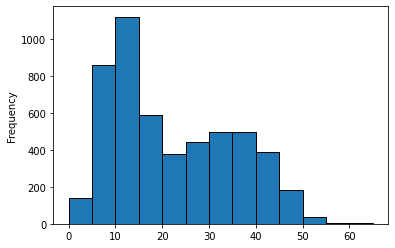

In [44]:
bins = [0, 5, 10,15,20, 25,30,35,40,45,50,55,60,65]

tweets['word_count'].plot(kind = 'hist', edgecolor = 'black', bins = bins)
plt.show()

## Wordclouds

In [45]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('twitteruser')
stopwords.append('Márki')
stopwords.append('Zay')
stopwords.append('Marki')
stopwords.append('Peter')
stopwords.append('Péter')

In [46]:
tweets_eng = tweets[tweets['tweet_language'] == 'en'][['tweet_full_text_processed']]

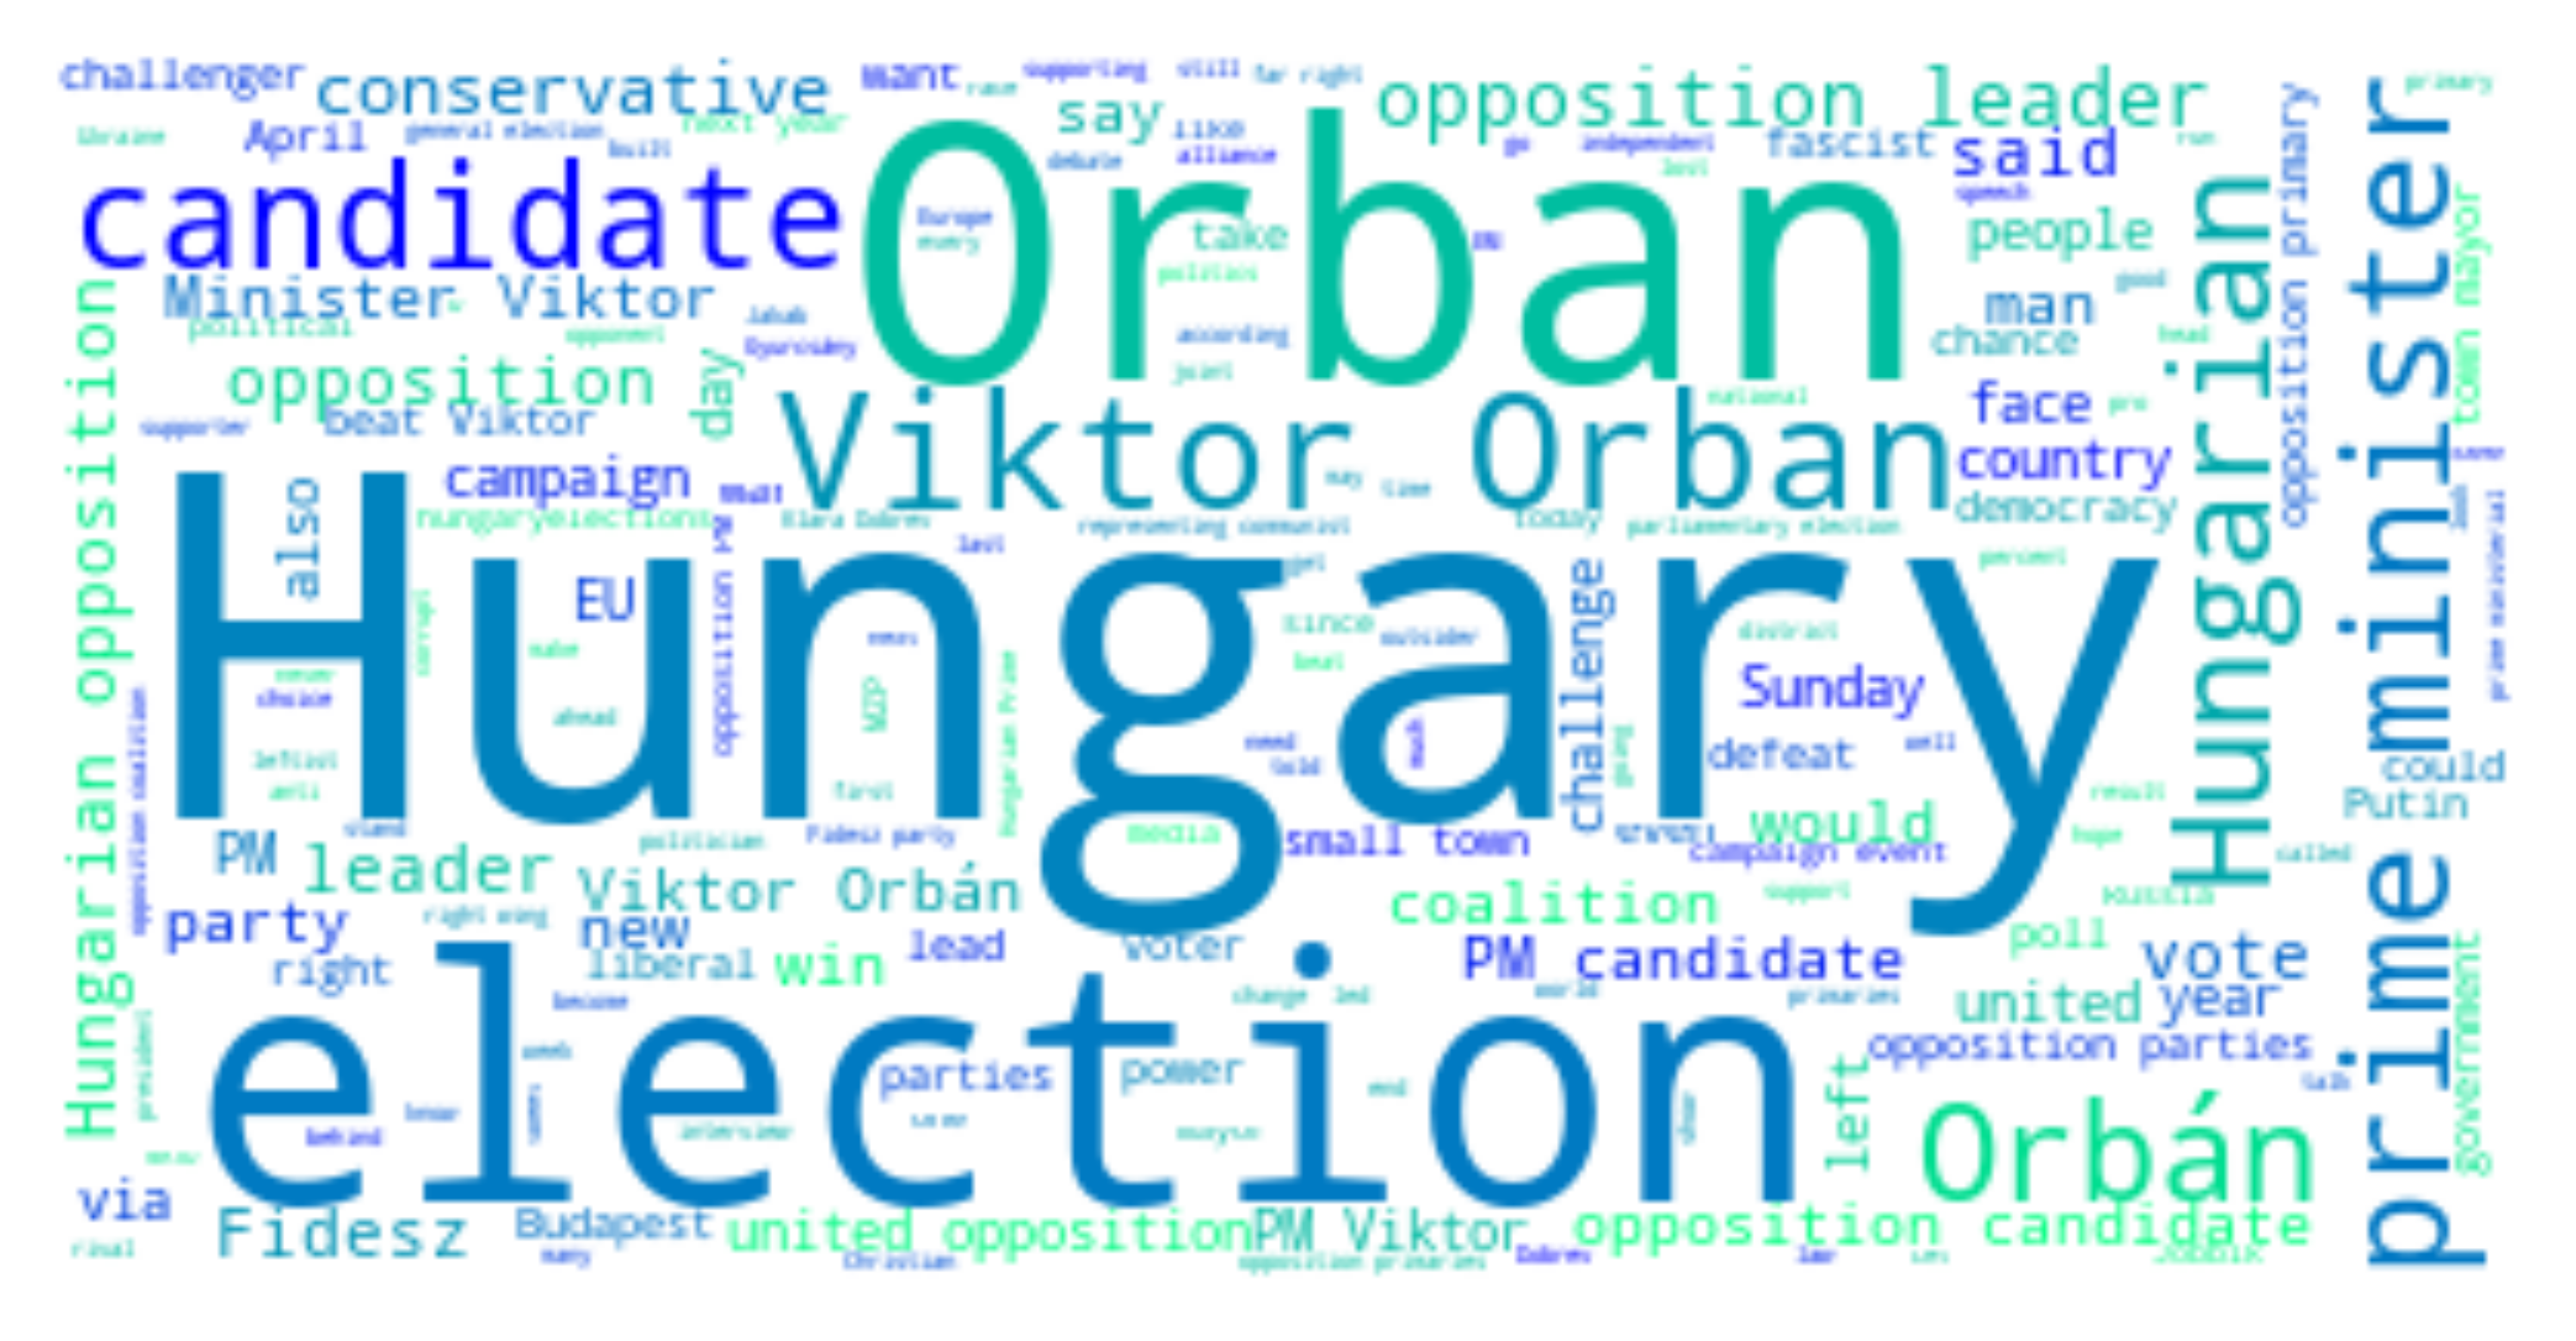

In [47]:
txt = " ".join(tweet for tweet in tweets_eng['tweet_full_text_processed'])
wordcloud = WordCloud(stopwords=stopwords, background_color ='white', colormap='winter').generate(txt)
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.gcf().set_dpi(600)
plt.show()

In [48]:
stopwords = nltk.corpus.stopwords.words('hungarian')
stopwords.append('twitteruser')
stopwords.append('Márki')
stopwords.append('Zay')
stopwords.append('Marki')
stopwords.append('Peter')
stopwords.append('Péter')
stopwords.append('i')

In [49]:
tweets_hu = tweets[tweets['tweet_language'] == 'hu'][['tweet_full_text_processed']]

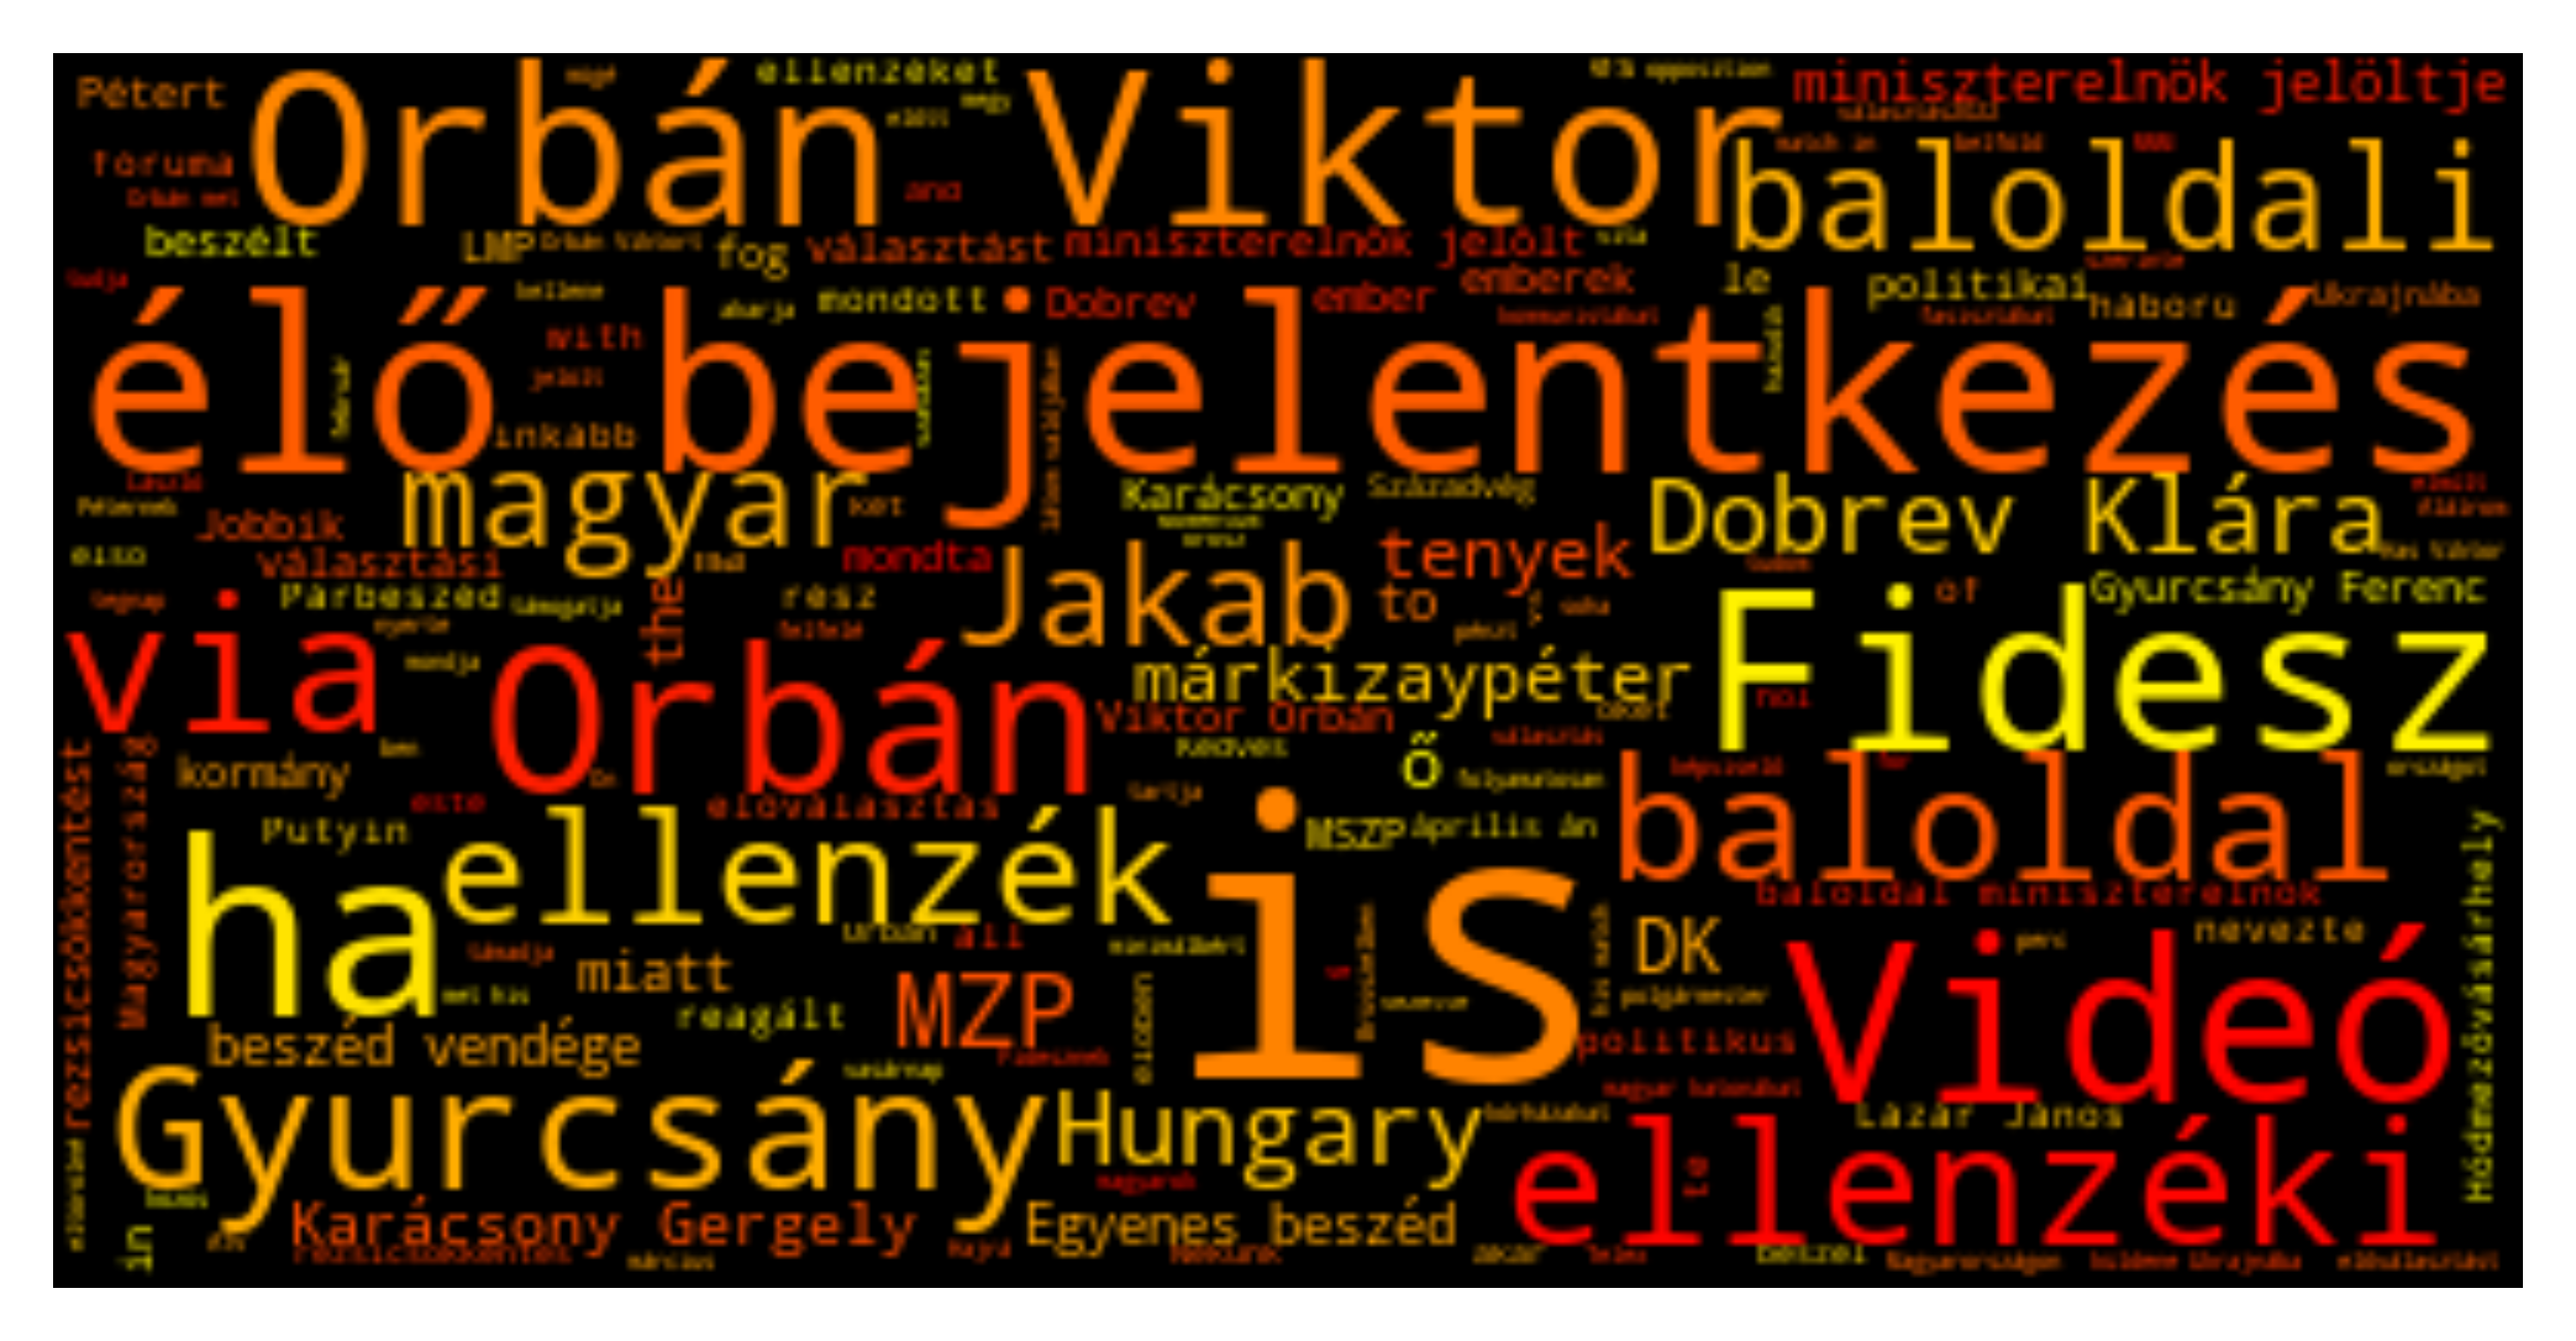

In [50]:
txt = " ".join(tweet for tweet in tweets_hu['tweet_full_text_processed'])
wordcloud = WordCloud(stopwords=stopwords, background_color ='black', colormap = 'autumn').generate(txt)
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.gcf().set_dpi(600)
plt.show()

# Sentiment analysis

## Sentiment overview

In [51]:
# Download a file based on its file ID.

# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1IFhdcb2B9SWYgrrhiPODyep5cgQN0qq4' # Check your own ID in GDrive
downloaded = drive.CreateFile({'id': file_id})

# Save file in Colab memory
downloaded.GetContentFile('scores.csv')

In [52]:
tweets = df[df['original_tweet_id'] == 'None']
scores = pd.read_csv('scores.csv', sep = ';')
tweets_with_scores = tweets.merge(scores, on = 'tweet_id', how = 'inner')

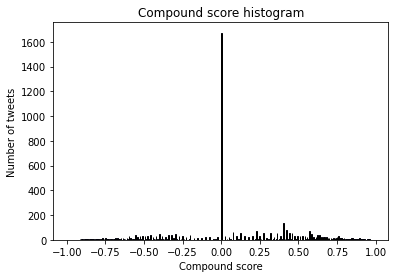

In [53]:
plt.hist(tweets_with_scores['compound'], color = 'blue', edgecolor = 'black', bins = 468)
plt.title('Compound score histogram')
plt.xlabel('Compound score')
plt.ylabel('Number of tweets')
plt.show()

In [54]:
stat = pd.DataFrame()

In [55]:
stat['total_count'] = [tweets_with_scores.count()['tweet_id']]
stat['positive_count'] = tweets_with_scores[(tweets_with_scores['compound'] >= 0.5)&
                                            (tweets_with_scores['compound'] < 0.75)].count()['tweet_id']
stat['very_positive_count'] = tweets_with_scores[tweets_with_scores['compound'] >= 0.75].count()['tweet_id']
stat['negative_count'] = tweets_with_scores[(tweets_with_scores['compound'] <= -0.5)&
                                            (tweets_with_scores['compound'] > -0.75)].count()['tweet_id']
stat['very_negative_count'] = tweets_with_scores[tweets_with_scores['compound'] <= -0.75].count()['tweet_id']

In [56]:
stat

total_count  positive_count  very_positive_count  negative_count  \
0         5127             606                  364             384   

   very_negative_count  
0                  160

## Retweets sentiment stat

In [57]:
 retweet_count = df[df['original_tweet_id'] != 'None']\
                  .groupby(['original_tweet_id'], as_index = False)\
                  .agg(retweet_count = ('tweet_id', 'count'))

 retweet_count['original_tweet_id'] = retweet_count['original_tweet_id'].astype('int64')
 
 tweets_with_scores2 = scores\
                      .merge(retweet_count, right_on = 'original_tweet_id',
                             left_on = 'tweet_id',
                             how = 'left')
 tweets_with_scores2['retweet_count'].fillna(0, inplace = True)

In [58]:
def _determine_sentiment(x):
    if x >= 0.5:
        sentiment = "positive"
    elif x <= -0.5:
        sentiment = "negative"
    else:
        sentiment = "neutral"
    return sentiment

In [59]:
tweets_with_scores2['sentiment'] = tweets_with_scores2['compound'].apply(lambda x: _determine_sentiment(x))
tweets_with_scores2.groupby(['sentiment'])['retweet_count'].describe()

count      mean        std  min  25%  50%  75%    max
sentiment                                                        
negative    544.0  1.540441   8.179964  0.0  0.0  0.0  1.0  134.0
neutral    3613.0  1.276502   4.801277  0.0  0.0  0.0  1.0  132.0
positive    970.0  2.146392  12.246826  0.0  0.0  0.0  1.0  289.0

## Sentiments in time

In [60]:
tweets_with_scores['sentiment'] = tweets_with_scores['compound'].apply(lambda x: _determine_sentiment(x))
tweets_with_scores['week_of_the_date'] =  pd.to_datetime(tweets_with_scores['tweet_created_at'],
                                                         format = "%Y-%m-%d", 
                                                         errors='coerce').dt.to_period('W')\
                                                         .apply(lambda r: r.start_time).dt.date
pivot = tweets_with_scores\
          .groupby(['week_of_the_date', 'sentiment'], as_index = False)['tweet_id'].count()\
          .pivot(index= 'week_of_the_date', columns = 'sentiment', values= 'tweet_id')\
          .fillna(0)
          
pivot['total'] = pivot['positive'] + pivot['negative'] + pivot['neutral']
pivot['pos_ratio'] = pivot['positive'] / pivot['total']
pivot['neg_ratio'] = pivot['negative'] / pivot['total']
pivot['neu_ratio'] = pivot['neutral'] / pivot['total']

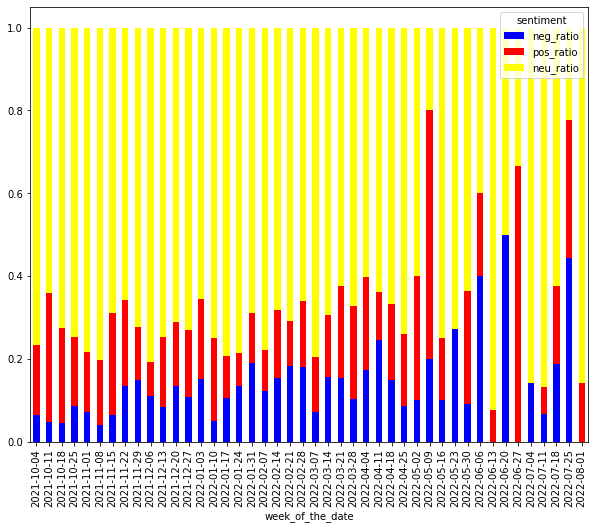

In [61]:
pivot[['neg_ratio','pos_ratio','neu_ratio']]\
.plot(kind = 'bar', stacked = True, color = ['blue', 'red', 'yellow'], figsize = (10, 8))
plt.show()


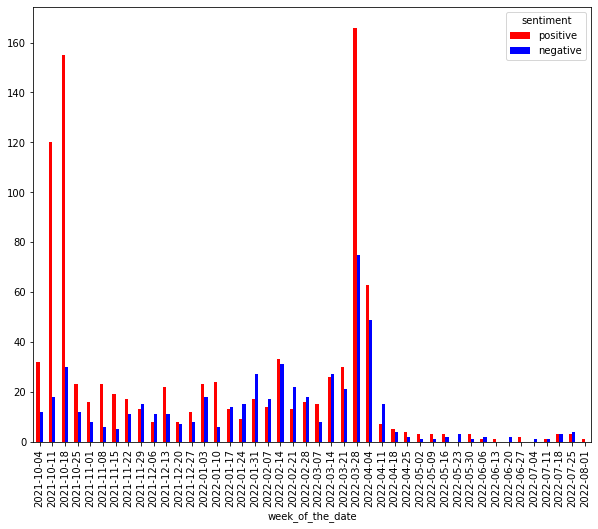

In [62]:
pivot[['positive','negative']]\
.plot(kind = 'bar', stacked = False, color = ['red', 'blue'], figsize = (10, 8))
plt.show()

## Locations and sentiments

In [63]:
df_detected_locations_s = df_detected_locations.merge(tweets_with_scores, how = 'inner', on = 'tweet_id')
pivot2 = df_detected_locations_s\
          .groupby(['country', 'sentiment'], as_index = False)['tweet_id'].count()\
          .pivot(index= 'country', columns = 'sentiment', values= 'tweet_id')\
          .fillna(0)

pivot2['total'] = pivot2['positive'] + pivot2['negative'] + pivot2['neutral']
pivot2['pos_ratio'] = pivot2['positive'] / pivot2['total']
pivot2['neg_ratio'] = pivot2['negative'] / pivot2['total']
pivot2['neu_ratio'] = pivot2['neutral'] / pivot2['total']

pivot2 = pivot2[pivot2.index != 'Other'].sort_values('total', ascending =False).head(20)

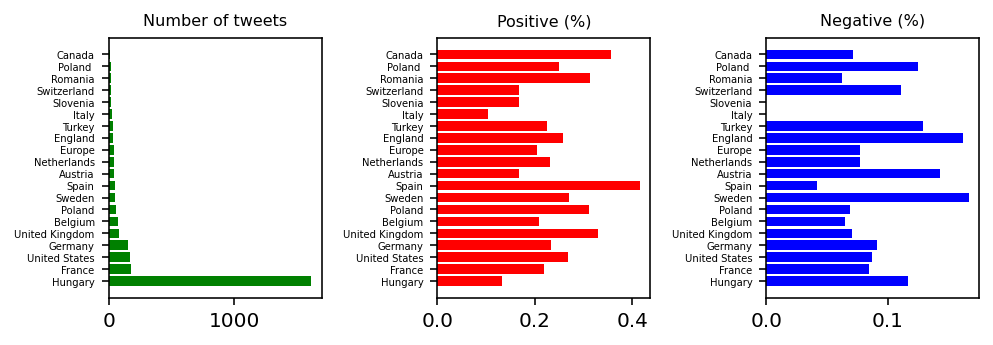

In [64]:
fig, ax = plt.subplots(1, 3, figsize=(7, 2.5), dpi=144, tight_layout=True)

index = [i for i in range(len(pivot2.index))]

ax[0].barh(y = pivot2.index, width = pivot2['total'], color = 'g')
ax[0].set_title('Number of tweets', fontsize = 8)
ax[0].tick_params(axis="y", labelsize=5)

ax[1].barh(pivot2.index, width = pivot2['pos_ratio'], color = 'r')
ax[1].set_title('Positive (%)', fontsize = 8)
ax[1].tick_params(axis="y", labelsize=5)

ax[2].barh(pivot2.index, width = pivot2['neg_ratio'], color = 'b')
ax[2].tick_params(axis="y", labelsize=5)
ax[2].set_title('Negative (%)', fontsize = 8)
plt.show()

## Languages and sentiments

In [65]:
# Download a file based on its file ID.

# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1_caJSStpTsMhffCc0_kQMChJjkNy_7xc' # Check your own ID in GDrive
downloaded = drive.CreateFile({'id': file_id})

# Save file in Colab memory
downloaded.GetContentFile('tweets_detected_lang.csv')

In [66]:
df_det_lang = pd.read_csv('tweets_detected_lang.csv', sep = ';')
detected_lang = tweets_with_scores.merge(df_det_lang, on = 'tweet_id', how = 'left')

detected_lang['tweet_language_y'].fillna(detected_lang['tweet_language_x'], inplace = True)

pivot3 = detected_lang\
          .groupby(['tweet_language_y', 'sentiment'], as_index = False)['tweet_id'].count()\
          .pivot(index= 'tweet_language_y', columns = 'sentiment', values= 'tweet_id')\
          .fillna(0)

pivot3['total'] = pivot3['positive'] + pivot3['negative'] + pivot3['neutral']

pivot3['pos_ratio'] = pivot3['positive'] / pivot3['total']
pivot3['neg_ratio'] = pivot3['negative'] / pivot3['total']
pivot3['neu_ratio'] = pivot3['neutral'] / pivot3['total']

pivot3 = pivot3.sort_values('total', ascending =False).head(10)

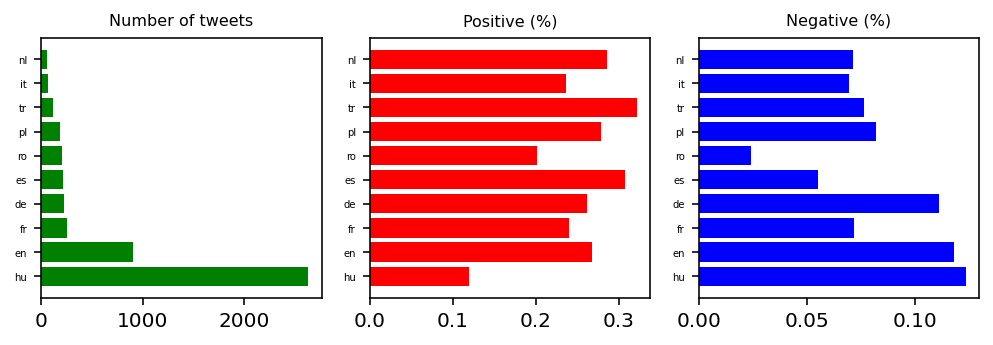

In [67]:
fig, ax = plt.subplots(1, 3, figsize=(7, 2.5), dpi=144, tight_layout=True)

index = [i for i in range(len(pivot3.index))]

ax[0].barh(y = pivot3.index, width = pivot3['total'], color = 'g')
ax[0].set_title('Number of tweets', fontsize = 8)
ax[0].tick_params(axis="y", labelsize=5)

ax[1].barh(pivot3.index, width = pivot3['pos_ratio'], color = 'r')
ax[1].set_title('Positive (%)', fontsize = 8)
ax[1].tick_params(axis="y", labelsize=5)

ax[2].barh(pivot3.index, width = pivot3['neg_ratio'], color = 'b')
ax[2].tick_params(axis="y", labelsize=5)
ax[2].set_title('Negative (%)', fontsize = 8)
plt.show()